<a href="https://colab.research.google.com/github/miltonospina/cv_lvl/blob/main/CV_shut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
###
#cap =  cv2.VideoCapture("/content/drive/MyDrive/Shut molinos/20200716_114031.mp4")
#ret, img = cap.read()

img = cv2.imread("/content/drive/MyDrive/Shut molinos/og2.png")

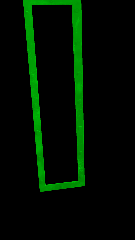

In [4]:
# convierte la imagen a hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# crea la mascara verde
mask1 = cv2.inRange(hsv, (36, 30, 0), (70, 255, 255))

#aplica la máscara
target = cv2.bitwise_and(img, img, mask=mask1)

#presenta la imagen del marco
(h, w) = target.shape[:2]
cv2_imshow( cv2.resize(target , (int(w*0.125), int(h*0.125))))

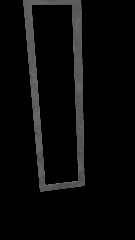

In [5]:
imgGry = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
ret, thrash = cv2.threshold(imgGry, 240, 255, cv2.CHAIN_APPROX_SIMPLE)

cv2_imshow( cv2.resize(thrash , (int(w*0.125), int(h*0.125))))

In [6]:
contours, hierarchy = cv2.findContours(
    thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
max_arcLen = 0
innerContour = 0
ventana = 0
for contour in contours:
    arcLen = cv2.arcLength(contour, True)
    if arcLen > max_arcLen:
        max_arcLen = cv2.arcLength(contour, True)
    if arcLen > 100:
        if innerContour > arcLen:
            innerContour = arcLen
        if innerContour == 0:
            innerContour = arcLen
        epsilon = 0.01*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x = approx.ravel()[0]
        y = approx.ravel()[1]
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspectRatio = float(w)/h
            if innerContour == arcLen:
                ventana = approx

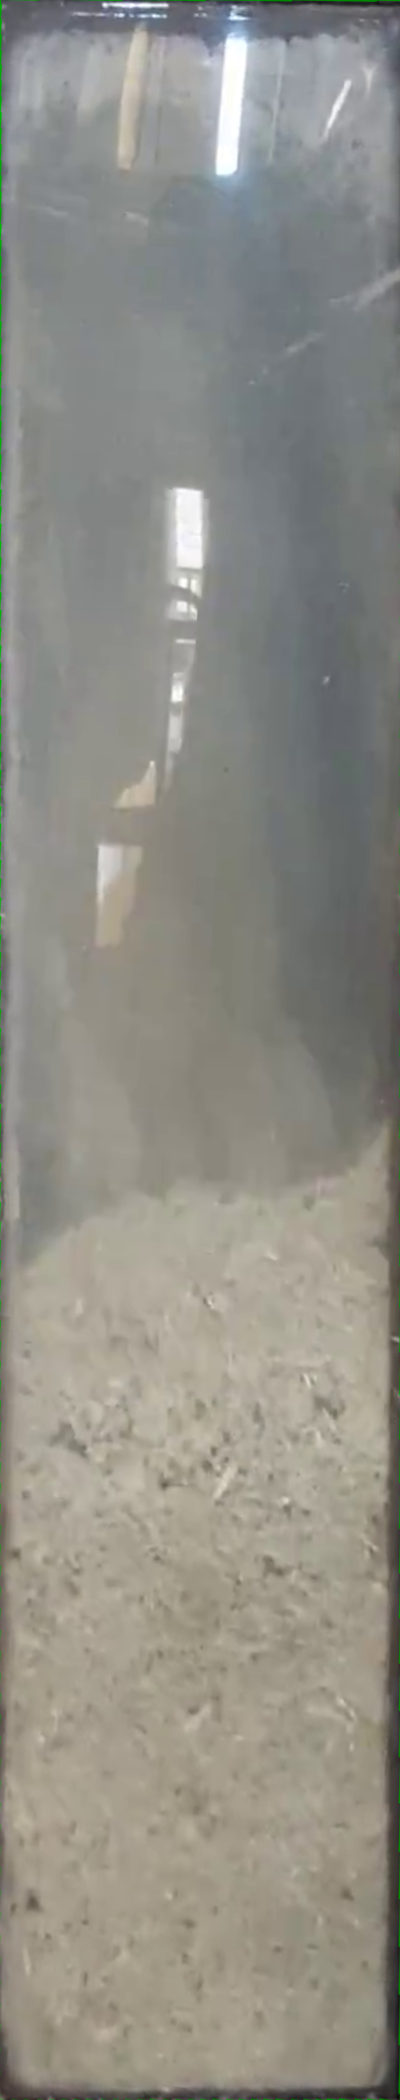

In [7]:
#identificar los puntos para recorte
p1 = ventana[3][0]
p2 = ventana[2][0]
p3 = ventana[1][0]
p4 = ventana[0][0]

pts1 = np.float32([p1,p4,p2,p3])
pts2 = np.float32([[0,0],[400,0],[0,2100],[400,2100]])

M = cv2.getPerspectiveTransform(pts1,pts2)
transformada = cv2.warpPerspective(img,M,(400,2100))

(h, w) = img.shape[:2]
cv2_imshow( cv2.resize(transformada , (400, 2100)))